In [ ]:
import os
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/My Drive/NNDL_Project_Data_Zipped/WBC_100_train.zip"
extract_path = "/content/WBC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import zipfile

zip_path = "/content/drive/My Drive/NNDL_Project_Data_Zipped/WBC_test.zip"
extract_path = "/content/WBC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

**Loading PRCC Model and defining the function for PRCC_Model Feature Extraction**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        self._initialize_weights()  # Apply Kaiming initialization

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print("Device:", device)

    # Instantiate the Autoencoder class
    prcc_model = Autoencoder().to(device)
    # Load the saved model state
    model_path = '/content/drive/My Drive/nndlprojectdata/pRCC/autoencoder_model_complex.pth'
    prcc_model.load_state_dict(torch.load(model_path, map_location=device))
    for param in prcc_model.parameters():
        param.requires_grad = False
    prcc_model.eval()
    print('PRCC Model loaded')

except Exception as e:
    print("Error:", e)


PRCC Model loaded


In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("Device:", device)

class PRCC_DataLoaderWrapper:
    def __init__(self, data_path, batch_size=8, num_workers=2, image_size=(2000, 2000)):
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

        self.dataset = ImageFolder(root=self.data_path, transform=self.transform)
        self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def get_features(self, model, device):
        for images, _ in self.loader:
            with torch.no_grad():
                prcc_features = model(images.to(device))
            return prcc_features


prcc_model.to(device)


prcc_data_path = '/content/WBC/WBC_100/train'
prcc_data_loader = PRCC_DataLoaderWrapper(prcc_data_path)

prcc_features = prcc_data_loader.get_features(prcc_model.encoder, device)

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 250 * 250, 64)
        self.fc2 = nn.Linear(64, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 250 * 250)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def prcc_model_features(images):
    prcc_features1 = prcc_features

    custom_model = CustomModel()

    # Move the model to the same device as the data
    custom_model.to(device)

    # Move the features to the same device as the model
    prcc_features2 = prcc_features1.to(device)

    with torch.no_grad():
        output = custom_model(prcc_features2)

    #print("Output shape:", output.shape)
    return output  # Output shape: torch.Size([batchsize, 5])

print("PRCC Feature Extraction Function Ready")


PRCC Feature Extraction Function Ready


**Loading CAM16 Model and defining the function for CAM16_Model Feature Extraction**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("Device:", device)

class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ModifiedNeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ModifiedNeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

try:
    # Instantiate the modified model
    cam16_model = ModifiedNeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)

    # Load the saved state dictionary
    model_dict = torch.load('/content/drive/My Drive/nndlprojectdata/CAM16/cam16_model.pth')

    # Adjust the dimensions of the fully connected layer to match the number of classes
    fc_weight = model_dict['fc.weight']
    fc_bias = model_dict['fc.bias']
    num_features = fc_weight.shape[1]
    modified_fc_weight = torch.randn(5, num_features)
    modified_fc_weight[:fc_weight.shape[0], :] = fc_weight  # Copy weight values from the loaded state dictionary
    modified_fc_bias = torch.randn(5)
    modified_fc_bias[:fc_bias.shape[0]] = fc_bias  # Copy bias values from the loaded state dictionary

    # Update the state dictionary with the modified fully connected layer dimensions
    model_dict['fc.weight'] = modified_fc_weight
    model_dict['fc.bias'] = modified_fc_bias

    # Load the modified state dictionary
    cam16_model.load_state_dict(model_dict)
    for cam in cam16_model.parameters():
        cam.requires_grad = False
    cam16_model.eval()
    print("CAM16 Model loaded")

except Exception as e:
    print("Error:", e)


CAM16 Model loaded


In [ ]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.utils.data as data


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("Device:", device)

class DataLoaderWrapper:
    def __init__(self, data_path, batch_size=8, num_workers=1, image_size=(384, 384)):
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

        self.dataset = ImageFolder(root=self.data_path, transform=self.transform)
        self.loader = data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def get_features(self, model, device):
        for images, _ in self.loader:
            cam16_features = model(images.to(device))
            return cam16_features

# Usage
cam16_data_path = '/content/WBC/WBC_50/train'
cam16_data_loader = DataLoaderWrapper(cam16_data_path)



def cam16_model_features(images):
    cam16_features = cam16_data_loader.get_features(cam16_model, device)
    #print("Cam16 Features shape:", cam16_features.shape)
    return(cam16_features)


print("CAM16 Feature Extraction Function Ready")


CAM16 Feature Extraction Function Ready


**Transfer Learning Model**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define data augmentation and preprocessing for training dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Preprocess the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_path = "/content/WBC/WBC_100/train/data"
trainset = ImageFolder(root=train_path, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)


validation_path="/content/WBC/WBC_test/val/data"
validationset = ImageFolder(root=validation_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=True, num_workers=2)



class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class NeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



def pad_labels(labels, batch_size):
  if labels.shape[0] != batch_size:
    padded_labels = torch.zeros(batch_size, dtype=labels.dtype, device=labels.device)
    padded_labels[:labels.shape[0]] = labels
    return padded_labels
  else:
    return labels

# Initialize weights and add L2 regularization
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

net = NeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)

# Initialize weights and add L2 regularization
net.apply(initialize_weights)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)

train_accuracy_list = []
train_loss_list = []
validation_accuracy_list = []
validation_loss_list = []

# Training loop
for epoch in range(25):
    running_loss = 0.0
    total = 0
    correct = 0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        prcc_features_tensor=prcc_model_features(inputs)
        cam16_features_tensor=cam16_model_features(inputs)
        combined_features = prcc_features_tensor + cam16_features_tensor

        optimizer.zero_grad()
        wbc_outputs= net(inputs)
        combined_features += wbc_outputs
        padded_labels = pad_labels(labels, combined_features.shape[0])
        # Calculate the cross-entropy loss.
        loss = criterion(combined_features, padded_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy in each iteration
        _, predicted = torch.max(combined_features, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total


    # Calculate validation accuracy and loss at the end of each epoch
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            prcc_features_tensor=prcc_model_features(images)
            cam16_features_tensor=cam16_model_features(images)
            combined_features1 = prcc_features_tensor + cam16_features_tensor

            outputs = net(images)
            combined_features1 += outputs
            padded_labels = pad_labels(labels, combined_features.shape[0])
            # Calculate the cross-entropy loss.
            loss = criterion(combined_features1, padded_labels)
            validation_loss += loss.item()  # Accumulate validation loss
            _, predicted = torch.max(combined_features1.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    validation_accuracy_list.append(validation_accuracy)
    validation_loss /= len(testloader)
    validation_loss_list.append(validation_loss)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(loss.item())
    scheduler.step(validation_accuracy)

    print(f"Epoch {epoch + 1},Training Accuracy: {train_accuracy:.2f}%, "
          f"Training Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation Loss: {validation_loss:.4f}")

print("Finished Training")

Device: cuda:0
Epoch 1,Training Accuracy: 72.25%, Training Loss: 0.9708, Validation Accuracy: 70.14%, Validation Loss: 0.9137
Epoch 2,Training Accuracy: 81.17%, Training Loss: 1.2798, Validation Accuracy: 54.57%, Validation Loss: 0.9036
Epoch 3,Training Accuracy: 83.67%, Training Loss: 0.9800, Validation Accuracy: 70.89%, Validation Loss: 0.7448
Epoch 4,Training Accuracy: 85.94%, Training Loss: 0.2338, Validation Accuracy: 85.71%, Validation Loss: 0.5476
Epoch 5,Training Accuracy: 86.19%, Training Loss: 0.2447, Validation Accuracy: 81.25%, Validation Loss: 0.5667
Epoch 6,Training Accuracy: 86.86%, Training Loss: 0.5256, Validation Accuracy: 57.47%, Validation Loss: 0.8896
Epoch 7,Training Accuracy: 87.67%, Training Loss: 0.1747, Validation Accuracy: 81.66%, Validation Loss: 0.5988
Epoch 8,Training Accuracy: 88.32%, Training Loss: 0.5572, Validation Accuracy: 79.17%, Validation Loss: 0.6467
Epoch 9,Training Accuracy: 89.01%, Training Loss: 0.7079, Validation Accuracy: 82.29%, Validation

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_validation_accuracy = 100 * correct / total

print(f"Final Validation Accuracy on WBC-100 => with Pretraining: {final_validation_accuracy:.2f} %")

Final Validation Accuracy on WBC-100 => with Pretraining: 93.04 %


In [ ]:
print("Training Loss:",train_loss_list)
print("Training Accuracy:",train_accuracy_list)
print("Testing (Validation) Loss:",validation_loss_list)
print("Testing (Validation) Accuracy:",validation_accuracy_list)

Training Loss: [0.9708272218704224, 1.2798069715499878, 0.9800023436546326, 0.23382550477981567, 0.24472707509994507, 0.5256441831588745, 0.17472749948501587, 0.5571780800819397, 0.7078791856765747, 1.2643427848815918, 0.3128453195095062, 0.3681815266609192, 0.6106424331665039, 0.5643187165260315, 0.3228696584701538, 1.0509254932403564, 0.2637201249599457, 0.3616117238998413, 0.15386098623275757, 0.16460835933685303, 0.2044178992509842, 0.12207295745611191, 0.17101451754570007, 1.5124601125717163, 0.2831187844276428]
Training Accuracy: [72.24674346000646, 81.17127785552805, 83.66885563569814, 85.94035956507697, 86.18796425880073, 86.85542038970826, 87.67359242114328, 88.31951770911832, 89.00850468295833, 89.15922058348585, 91.00010765421466, 91.36613198406718, 91.64603294218969, 91.55990957045968, 92.08741522230595, 92.35655075896221, 92.65798256001723, 92.89482183227473, 93.97136397889977, 93.66993217784476, 93.70222844224351, 93.90677145010227, 94.18667240822478, 94.13284530089354, 9

In [ ]:
torch.save(net.state_dict(), '/content/drive/My Drive/nndlprojectdata/WBC_100/with_pretraining/wbc100_model_with_pretraining.pth')
print("Model Saved")

Model Saved


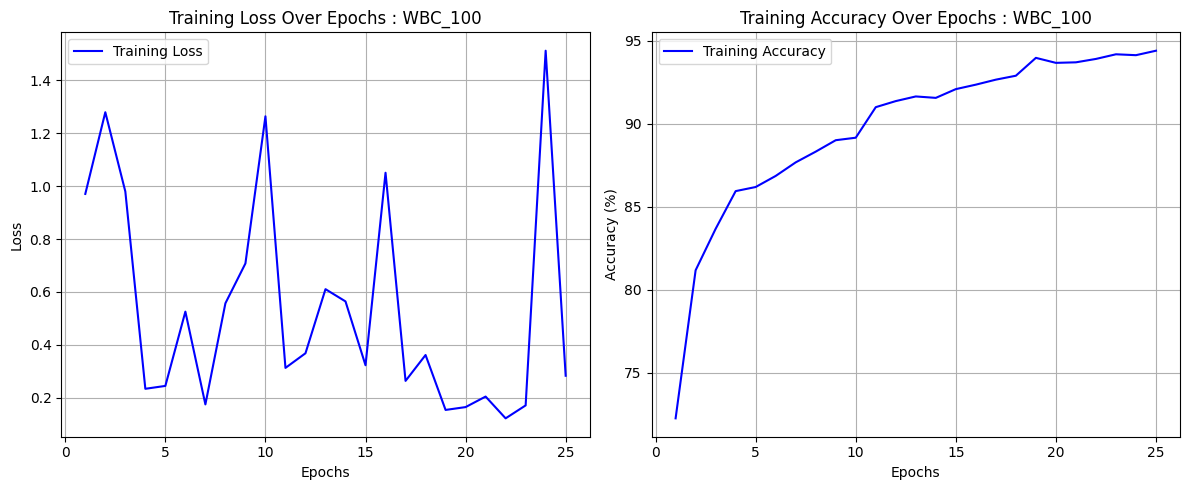

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss

epochs = range(1, len(train_accuracy_list) + 1)

# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs : WBC_100')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='blue')
plt.title('Training Accuracy Over Epochs : WBC_100')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

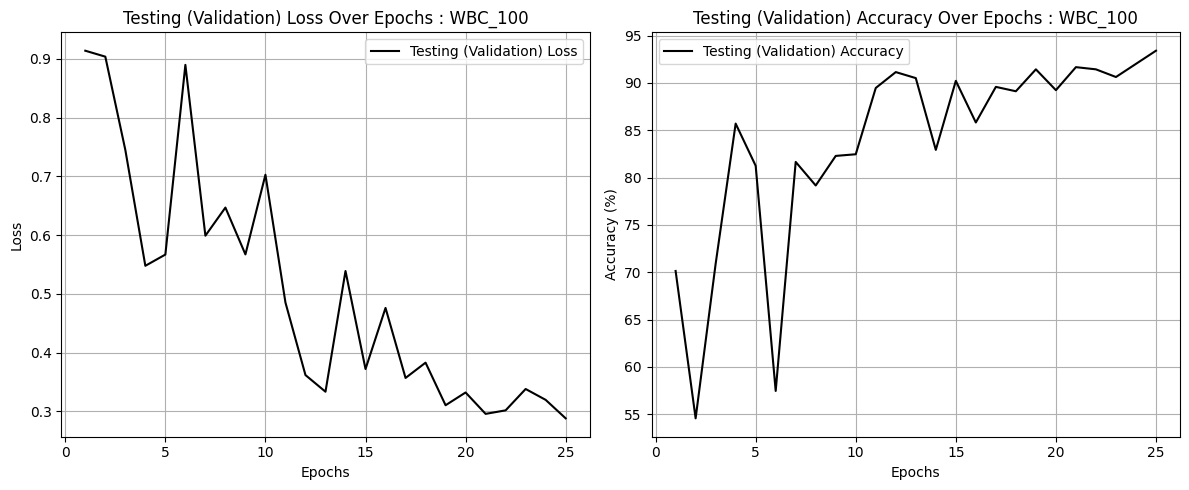

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss

epochs1 = range(1, len(train_accuracy_list) + 1)


# Create a list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
epochs = list(range(1, len(epochs1) + 1))

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, validation_loss_list, label='Testing (Validation) Loss', color='Black')
plt.title('Testing (Validation) Loss Over Epochs : WBC_100')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy_list, label='Testing (Validation) Accuracy', color='Black')
plt.title('Testing (Validation) Accuracy Over Epochs : WBC_100')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [ ]:
# Save the training loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/WBC_100/with_pretraining/training_metrics.txt', 'w') as f:
    f.write("Training Loss: " + str(train_loss_list) + "\n")
    f.write("\nTraining Accuracy: " + str(train_accuracy_list) + "\n")

# Save the validation loss and accuracy
with open('/content/drive/My Drive/nndlprojectdata/WBC_100/with_pretraining/validation_metrics.txt', 'w') as f:
    f.write("Testing (Validation) Loss: " + str(validation_loss_list) + "\n")
    f.write("\nTesting (Validation) Accuracy: " + str(validation_accuracy_list) + "\n")

**Calcualting the class-wise accuracies, F1 score and confusion matrix**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# redefining the classes used in the model

class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class NeuralNetwork(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)


    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# loading the model
loaded_model = NeuralNetwork(BasicResidualBlock, [2, 2, 2]).to(device)
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/nndlprojectdata/WBC_100/with_pretraining/wbc100_model_with_pretraining.pth'))
loaded_model.eval()  # Set the model to evaluation mode

# Preprocess the validation dataset
validation_path = "/content/WBC/WBC_test/val/data"
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

validationset = ImageFolder(root=validation_path, transform=transform_test)

# Create the test data loader
testloader = torch.utils.data.DataLoader(validationset, batch_size=8, shuffle=False, num_workers=2)

# Initialize class-wise variables
class_correct = list(0. for _ in range(5))
class_total = list(0. for _ in range(5))
class_names = validationset.classes

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print class-wise accuracy
for i in range(5):
    print(f"Accuracy of class {class_names[i]}: {100 * class_correct[i] / class_total[i]}%")


Device: cuda:0
Accuracy of class Basophil: 100.0%
Accuracy of class Eosinophil: 55.55555555555556%
Accuracy of class Lymphocyte: 97.0873786407767%
Accuracy of class Monocyte: 25.263157894736842%
Accuracy of class Neutrophil: 98.96128423040604%


F1 score: 0.900499252899882




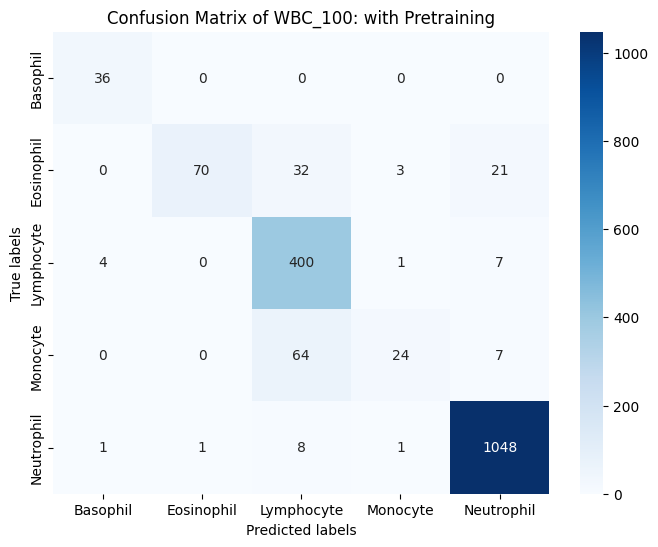

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score


true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            true_labels.append(label.cpu().numpy())
            predicted_labels.append(predicted[i].cpu().numpy())

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print(f"F1 score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
class_names = validationset.classes
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of WBC_100: with Pretraining')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
print("\n")
plt.show()
